In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm

import biosppy.signals
import pickle


In [ ]:
# Root folder for the data
data_folder = "/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data"
#Load the data
subject = 'MR012'
data_file = 'MR012_FM_aligned.mat'
data_file_path = os.path.join(data_folder,data_file)

# Retrieve Data

In [2]:
##  retrieve tensors ##
file = open('tensor_dump.pkl', 'rb')
raw_data_to_tensor = pickle.load(file)
amplitude_data_to_tensor  = pickle.load(file)
muscles_to_tensor = pickle.load(file)
elecs_to_tensor = pickle.load(file)

file.close()

In [3]:
## retrieve muscle and elec names

df_electrodes = pd.read_csv("df_electrodes.csv")
df_muscles= pd.read_csv("df_muscles.csv")

# Set Functions

## Saving the plots

In [102]:
save_flag=1
# subject_plots_folder_name=subject+'_plots'
data_folder = "/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data"
save_folder = os.path.join(data_folder,"Histogram")
os.makedirs(save_folder,exist_ok=True)

## Take muscle name and get the muscle nr, data tensor, amplitudes tensor and max EMG value

### Get the index nr for a muscle

In [195]:
def get_nr_for_muscle(muscle_name, df_muscles): # Input muscle_name Eg. "RRF"
    """
    Get index number of a muscle
    
    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    
    Returns:
    - muscle_nr int index of the muscle
    """
    print("function 'get_nr_for_muscle' has been called")
    muscle_nr=df_muscles.index.where(df_muscles.muscle_name==muscle_name).dropna().astype(int)[0]
    print(f"For muscle name: {muscle_name} the index number is: {muscle_nr} ")
 
    return int(muscle_nr)

In [196]:
muscle_nr=get_nr_for_muscle("RRF", df_muscles)# Input muscle_name Eg. "Vlat"

function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the raw data for a muscle

In [197]:
def get_raw_data_for_muscle(muscle_name, df_muscles, raw_data_to_tensor): # Input muscle_name Eg. "Vlat"
    """
    Get raw data tensor

    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    - raw_data_to_tensor 5D tensor all the raw data of all the muscles
    Returns:
    - data_tensor_muscle_i 4D tensor with the raw data for the muscle

    """
    print("function 'get_raw_data_for_muscle' has been called")
    muscle_nr=get_nr_for_muscle(muscle_name, df_muscles)
    data_tensor_muscle_i=raw_data_to_tensor[:,muscle_nr,:,:,:] #returns a tensor of size([16, 32, 11, 1404])
    return data_tensor_muscle_i

In [198]:
data_tensor_muscle_i= get_raw_data_for_muscle("RRF", df_muscles, raw_data_to_tensor)

function 'get_raw_data_for_muscle' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the amplitude data for a muscle

In [199]:
## Make a function that given a muscle name, returns the data tensor and amplitudes tensor related to this muscle. ##
def get_amplitude_data_for_muscle(muscle_name, df_muscles, amplitude_data_to_tensor): # Input muscle_name Eg. "Vlat"
    """
    Get amplitude data tensor
    
    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    - amplitude_data 3D tensor all the amplitude data of all the muscles
    Returns:
    tuple with:
    - amplitude_tensor_muscle_i 2D tensor with the amplitude data for the muscle
    """
   
    print("function 'gget_amplitude_data_for_muscle' has been called")
    muscle_nr=get_nr_for_muscle(muscle_name, df_muscles)
    amplitude_tensor_muslce_i=amplitude_data_to_tensor[:, muscle_nr, :] #returns a tensor of size([16, 32])
    
    return amplitude_tensor_muslce_i 

   

In [200]:
amplitude_tensor_muslce_i=get_amplitude_data_for_muscle("RRF", df_muscles, amplitude_data_to_tensor)

function 'gget_amplitude_data_for_muscle' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the max EMG value for a muscle

In [201]:

def get_max_emg(muscle_name, df_muscles, raw_data_to_tensor ): # Input muscle_name Eg. "Vlat"
    """
    This function gets the max value out of all the EMG values of a muscle
    
    Parameters:
    - muscle_name string the name of the muscle 
    - raw_data_to_tensor 5D tensor all the raw data of all the muscles

    Returns:
    - max_emg tensor the maximum emg value from all the values of the muscle, for normalisation
    """
    print("function 'get_max_emg' has been called")
    muscle_nr= get_nr_for_muscle(muscle_name, df_muscles)
    max_emg=np.nanmax(raw_data_to_tensor[:, muscle_nr, :, :, :])
    max_emgs=torch.tensor(max_emg)  #get tensor
    print(f"max_emg: {max_emg}")
    return max_emg



In [202]:
max_emg=get_max_emg("RRF", df_muscles, raw_data_to_tensor) 


function 'get_max_emg' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 
max_emg: 3.583035469055176


## Get peak to peak value

In [100]:
## take only one trial since overload of data otherwise
## got rid of nan columns

from cmath import isfinite


def get_peak_to_peak(EMG_time_series,  window_size, df_electrodes=df_electrodes, df_muscles=df_muscles, elec="all" ,muscle="all", amplitude="all"): 
    """
    This function returns an array and plot of peak to peak values for a given Time-series and window size
    Parameters:
    - EMG_time_series tensor an emg data series 
    - widow_size integer number of timepoints per window
    - df_muscles list of muscles, set by default
    - df_electrodes list of electrodes, set by default
    - elec integer nr of elec, by default all elecs
    - muscle integer muscle nr or name, by default all muscles
    - amplitude integer trial number, by defualt all amplitudes

    Return:
    - peak_to_peak_values tensor a tensor the peak to peak values for each windwo of the given time_series
    """
    
    print("function 'get_peak_to_peak' has been called")
    
    ### get peak_to_peak_value for each window ###
    peak_to_peak_values=[]
    EMG_time_series_without_nan=[]
    
    EMG_time_series=torch.flatten(EMG_time_series)
    for i in range (len(EMG_time_series)):
        if isfinite(EMG_time_series[i]):
            
            EMG_time_series_without_nan.append(EMG_time_series[i])
    EMG_time_series_without_nan=torch.tensor(EMG_time_series_without_nan)
    windows_per_trial=EMG_time_series_without_nan.unfold(0, window_size, 1)

    for window in windows_per_trial:
        max_y=np.nanmax(window) # find max and min for every window neglecting NAN
        min_y=np.nanmin(window)
        peak_to_peak_values.append(max_y-min_y) #calculate peak-to-peak for every window
    peak_to_peak_values=torch.tensor(peak_to_peak_values)  #get tensor

    ### set equal size for peak_to_peak_value and EMG_time_series_without_nan (filled with zeros) ###
    target_len = EMG_time_series_without_nan.size(dim=0)
    peak_to_peak_values=torch.nn.functional.pad(peak_to_peak_values, (0, target_len - peak_to_peak_values.size(dim=0)))
    print(EMG_time_series_without_nan.size())
    print(peak_to_peak_values.size())


    ##  Set variables for teh title #
    if (amplitude != "all"):
        print("amplitude is specific")
        amplitude=round(amplitude_data_to_tensor[elec, muscle, amplitude].item(), 1)
    if (elec != "all"):
        print("elec is specific")
        elec=df_electrodes.iloc[elec]['elec_name']
    if (muscle != "all"):
        print("muscle is specific")
        muscle=df_muscles.iloc[muscle]['muscle_name']  

    # ### plot results ###
    # figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    # figure.suptitle(f" Plots for elec: {elec}, muscle: {muscle}, amplitude: {amplitude}")
    # ## plot EMG values
    # axis[0].plot(EMG_time_series_without_nan)
    # axis[0].set(ylabel='EMG response')
    # axis[0].set_title("EMG Time series")
        
    # ## plot peak to peak values
    # axis[1].plot(peak_to_peak_values)
    # axis[1].set( ylabel='Peak to peak value in mV')
    # axis[1].yaxis.set_label_position("right")
    # axis[1].yaxis.tick_right()
    # axis[1].set_title("Peak to peak analysis of EMG time series")
    # plt.show()
            
    return peak_to_peak_values

## Get a Histogram

In [103]:
def get_histogram(peak_to_peak_values, bins, df_muscles=df_muscles, df_electrodes=df_electrodes,  elec="all" ,muscle="all", amplitude="all", trial="all"):
    """
    This function computes the histogram of the peak to peak values of a EMG series. 
    
    Parameters:

    - peak_to_peak_values tensor a tensor the peak to peak values for each window of the given time_series
    - bins integer nr of bins by that the time series should be divided to
    - df_muscles list of muscles, set by default
    - df_electrodes list of electrodes, set by default
    - elec integer nr of elec, by default all elecs
    - muscle integer muscle nr or name, by default all muscles
    - amplitude integer index of amplitude, by defualt all amplitudes
    - trial integer trial number, by default all trials

    Returns:
    - Plot with amount of EMG values per bin
    """
   
    print("function 'get_histogram' has been called")
    # Set variables for the title #
    if (amplitude != "all"):
        print("amplitude is specific")
        amplitude=round(amplitude_data_to_tensor[elec, muscle, amplitude].item(), 1)
    if (elec != "all"):
        print("elec is specific")
        elec=df_electrodes.iloc[elec]['elec_name']
    if (muscle != "all"):
        print("muscle is specific")
        muscle=df_muscles.iloc[muscle]['muscle_name']
    if (trial != "all"):
        print("trial is specific")
        trial=str(trial)

    ## define y and x values
    hist=torch.histc(torch.nan_to_num(peak_to_peak_values), bins=bins) #create a histogram
    x=np.linspace(np.nanmin(peak_to_peak_values), np.nanmax(peak_to_peak_values),bins ) # set x axis value that range from min value of df to max value
    
    ## plot settings 
    plt.figure(figsize = (10,5))
    plt.yscale("log") 
    plt.bar(x,hist, align='center',edgecolor="blue",  width=0.005)
    plt.title(f"Histogram for elec: {elec}, muscle: {muscle}, amplitude: {amplitude}, trial: {trial}")
    plt.xlabel('Peak to peak values in mV')
    plt.ylabel("Amount of peak to peak values in numbers")

    if save_flag:
        data_file = muscle+"_"+elec+"_"+trial+'.png'
        data_file_path = os.path.join(save_folder,data_file)
        plt.savefig(data_file_path, transparent = "True",  bbox_inches='tight')
    plt.show()

# Analysisng data

Do the analysis for all data and all the trials (have to be split up,due to overload otherwise)

In [ ]:
# for all the trials
histogram_individual_trial_all_data={}
for trial in range (len(raw_data_to_tensor[0,0,0,:,0])):
    
    histogram_individual_trial_all_data[f"trial_{trial}"]=get_histogram(get_peak_to_peak(raw_data_to_tensor[:,:,:,trial,:], 100), bins=100, trial=trial)
    

Do the analysis for all the muscles of an elec


function 'get_peak_to_peak' has been called
torch.Size([1276730])
torch.Size([1276730])
function 'get_histogram' has been called
elec is specific


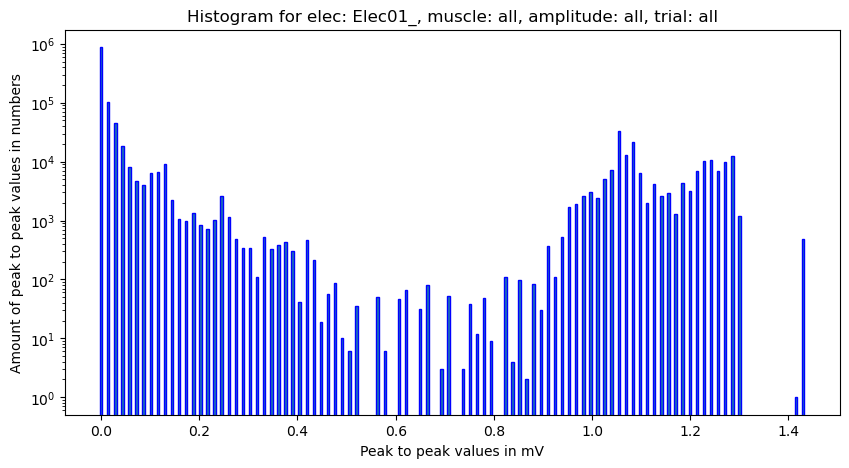

function 'get_peak_to_peak' has been called
torch.Size([1453522])
torch.Size([1453522])
function 'get_histogram' has been called
elec is specific


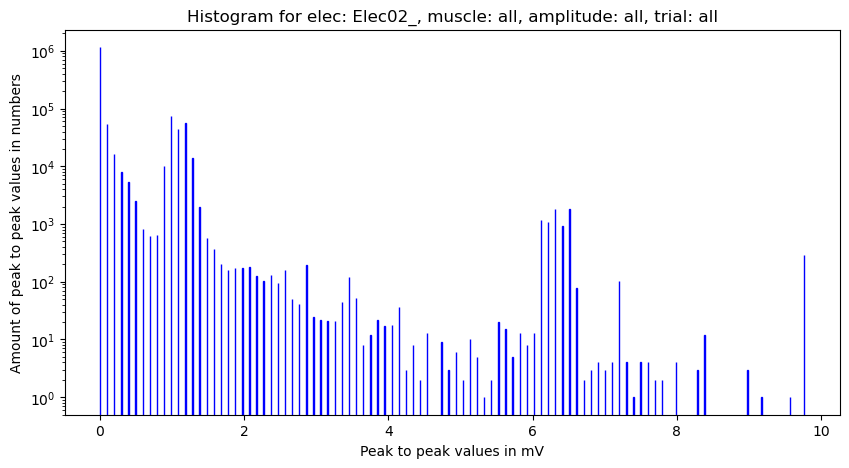

function 'get_peak_to_peak' has been called
torch.Size([1807260])
torch.Size([1807260])
function 'get_histogram' has been called
elec is specific


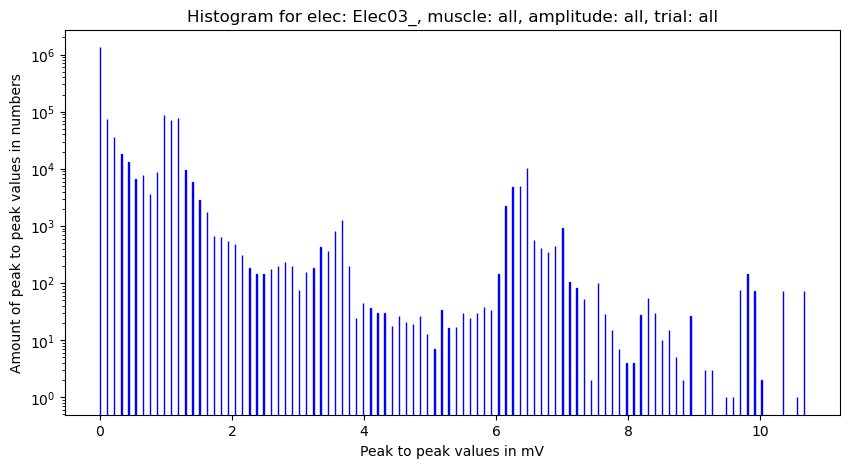

function 'get_peak_to_peak' has been called
torch.Size([1158892])
torch.Size([1158892])
function 'get_histogram' has been called
elec is specific


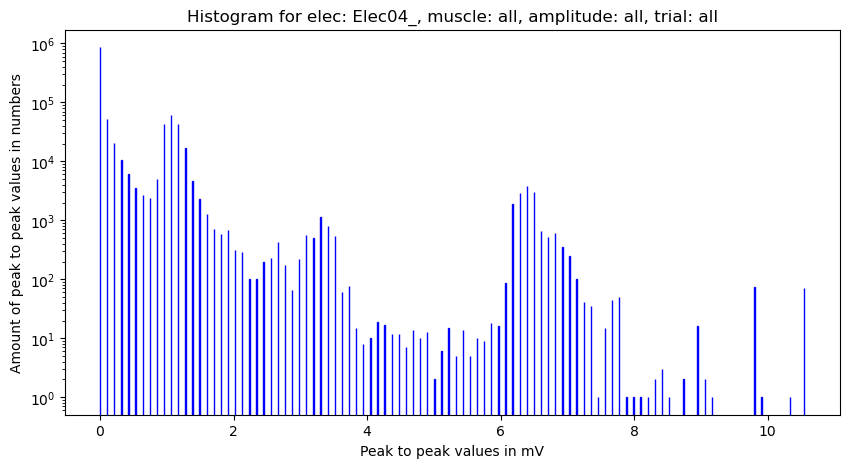

function 'get_peak_to_peak' has been called
torch.Size([805322])
torch.Size([805322])
function 'get_histogram' has been called
elec is specific


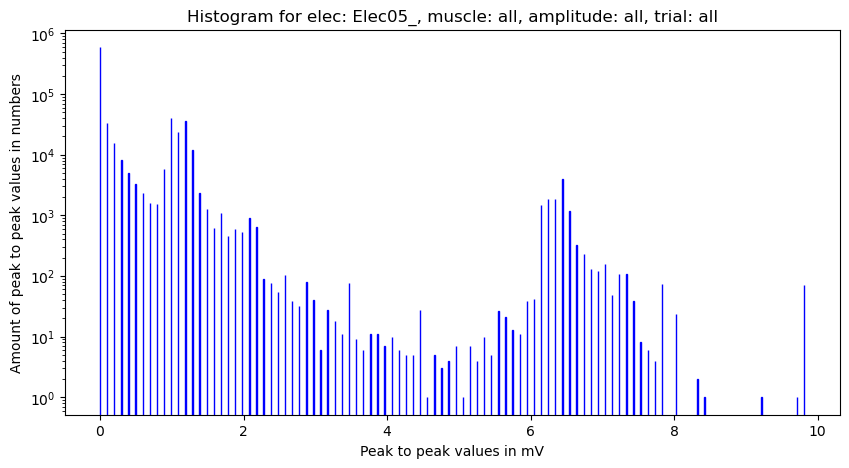

function 'get_peak_to_peak' has been called
torch.Size([648186])
torch.Size([648186])
function 'get_histogram' has been called
elec is specific


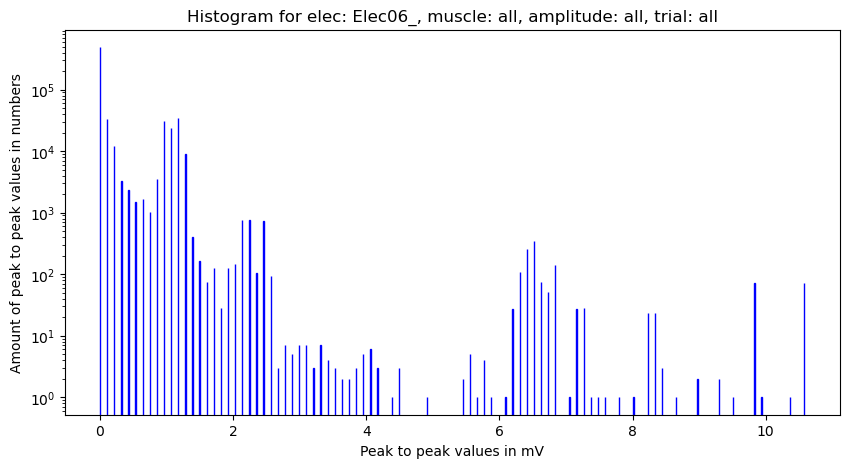

function 'get_peak_to_peak' has been called
torch.Size([962500])
torch.Size([962500])
function 'get_histogram' has been called
elec is specific


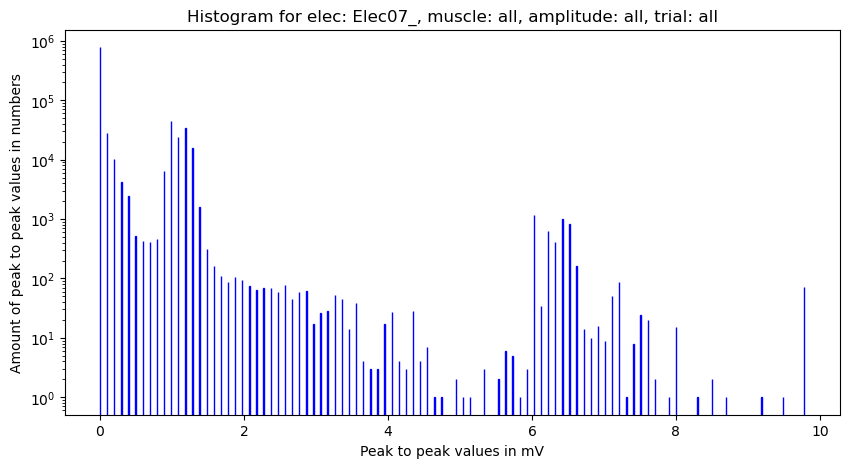

function 'get_peak_to_peak' has been called
torch.Size([1021398])
torch.Size([1021398])
function 'get_histogram' has been called
elec is specific


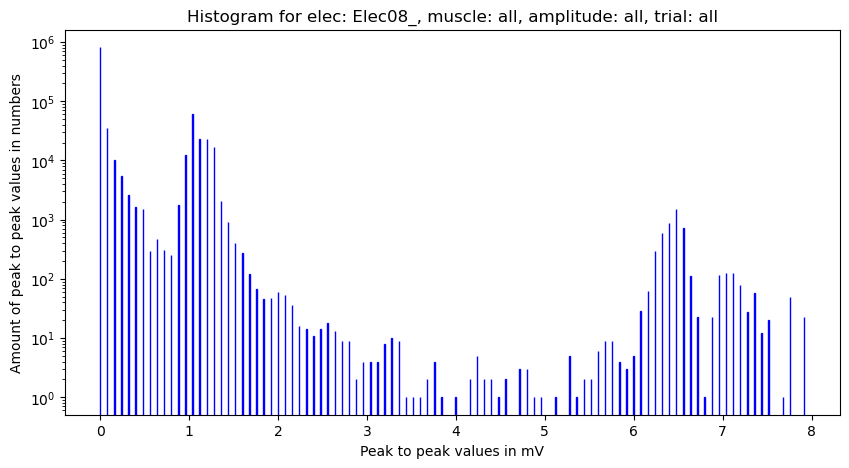

function 'get_peak_to_peak' has been called
torch.Size([1001756])
torch.Size([1001756])
function 'get_histogram' has been called
elec is specific


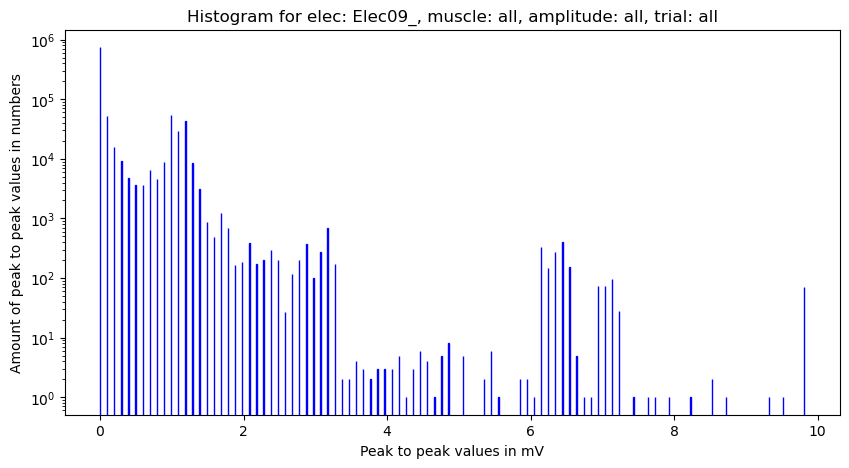

function 'get_peak_to_peak' has been called
torch.Size([766038])
torch.Size([766038])
function 'get_histogram' has been called
elec is specific


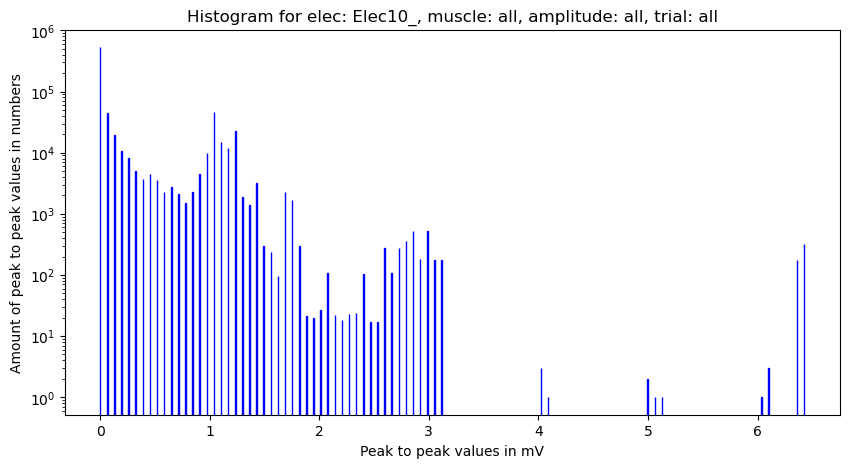

function 'get_peak_to_peak' has been called
torch.Size([628558])
torch.Size([628558])
function 'get_histogram' has been called
elec is specific


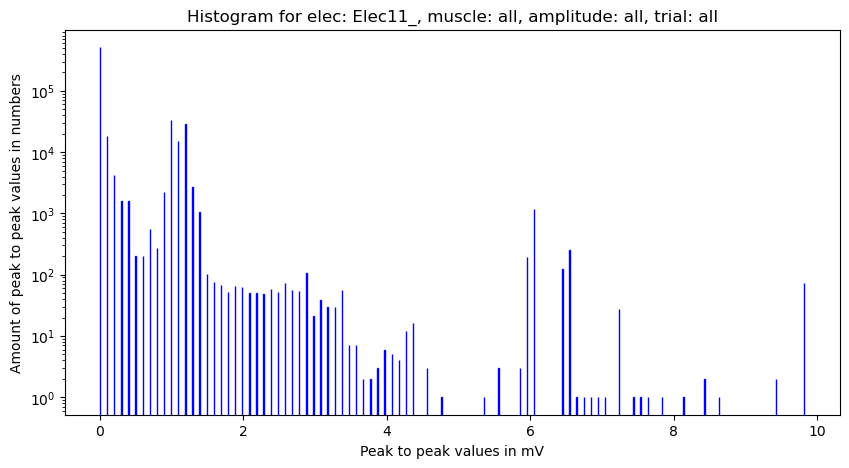

function 'get_peak_to_peak' has been called
torch.Size([982100])
torch.Size([982100])
function 'get_histogram' has been called
elec is specific


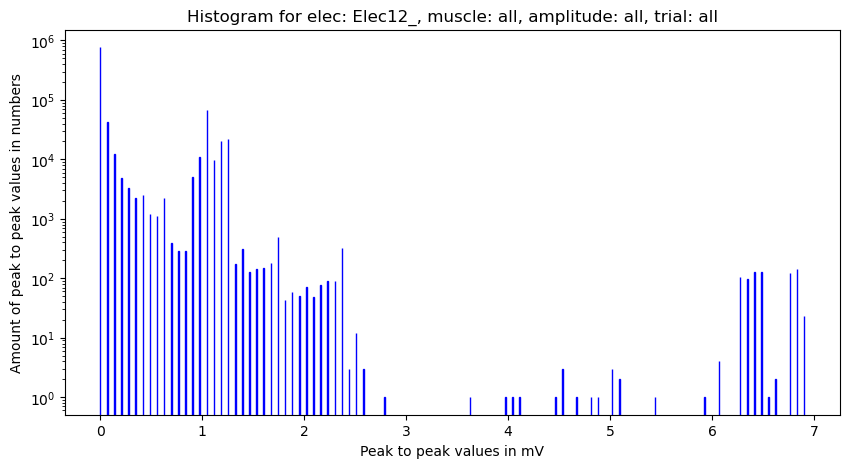

function 'get_peak_to_peak' has been called
torch.Size([1158892])
torch.Size([1158892])
function 'get_histogram' has been called
elec is specific


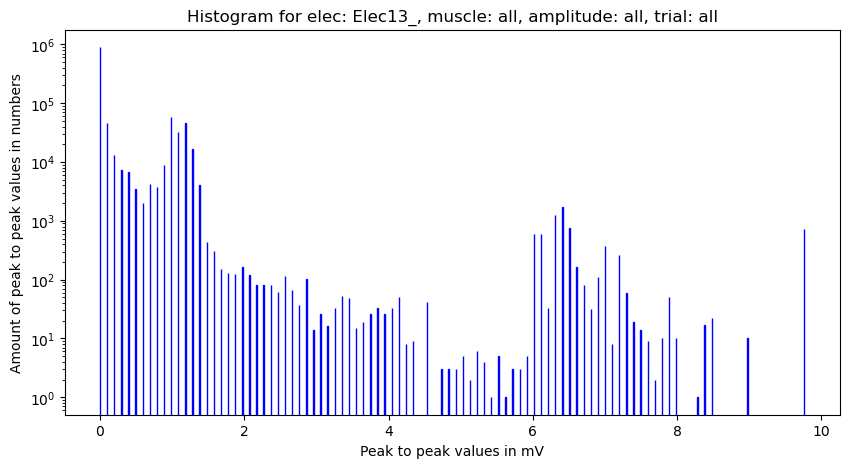

function 'get_peak_to_peak' has been called
torch.Size([726782])
torch.Size([726782])
function 'get_histogram' has been called
elec is specific


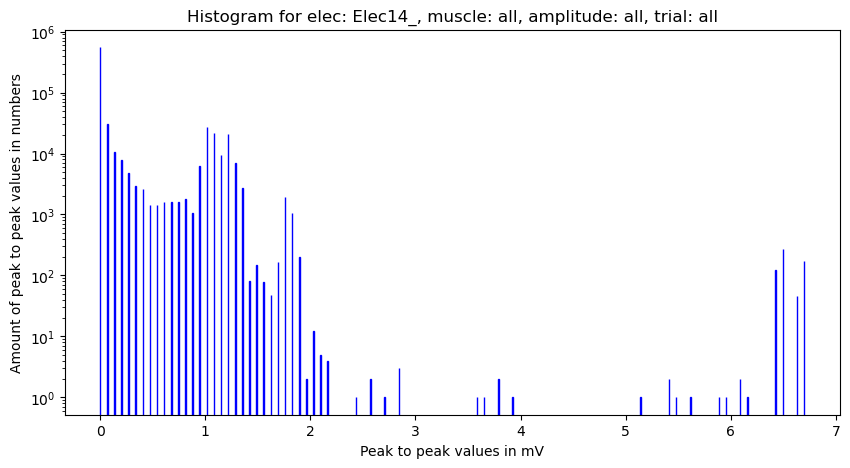

function 'get_peak_to_peak' has been called
torch.Size([1296414])
torch.Size([1296414])
function 'get_histogram' has been called
elec is specific


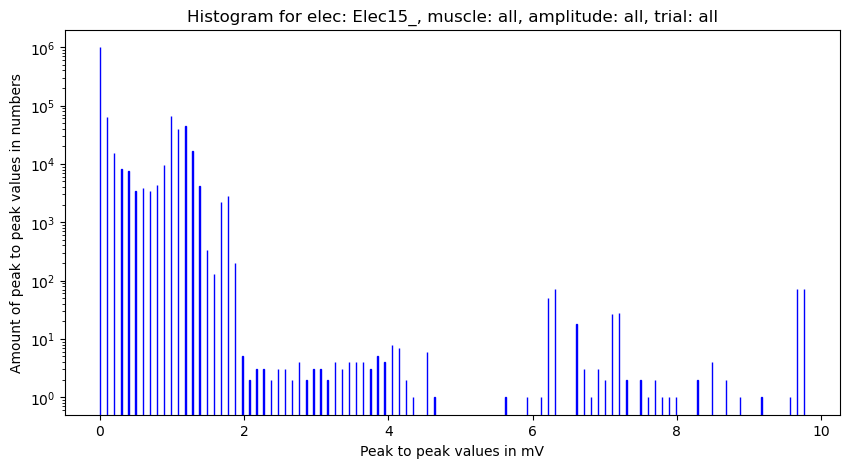

function 'get_peak_to_peak' has been called
torch.Size([864262])
torch.Size([864262])
function 'get_histogram' has been called
elec is specific


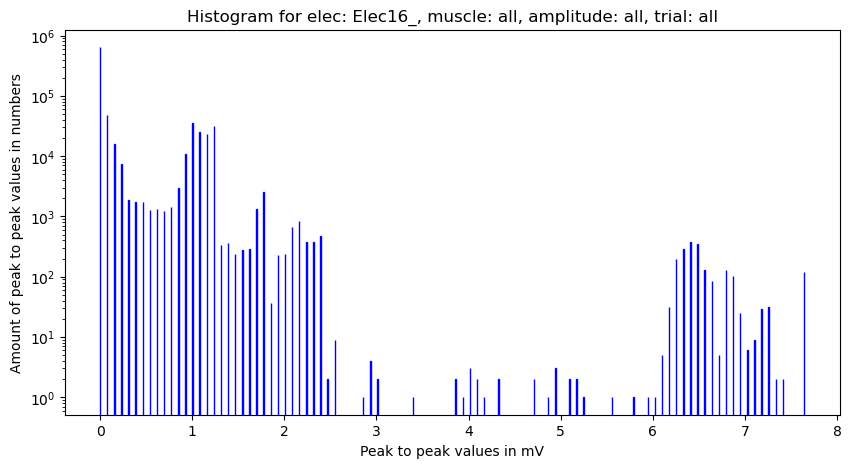

In [106]:

histogram_indvidual_elec_all_muscles={}
for elec in range (len(raw_data_to_tensor[:,0,0,0,0])):
    histogram_indvidual_elec_all_muscles[df_electrodes.iloc[elec]['elec_name']]=get_histogram(get_peak_to_peak(raw_data_to_tensor[elec,:,:,:,:], 100), bins=100, elec=elec)
    

Do the analysis for all elecs of a muscle

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


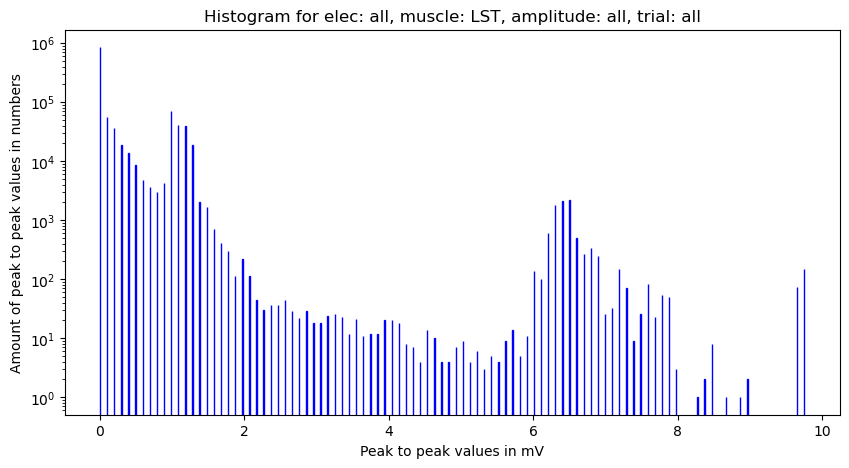

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


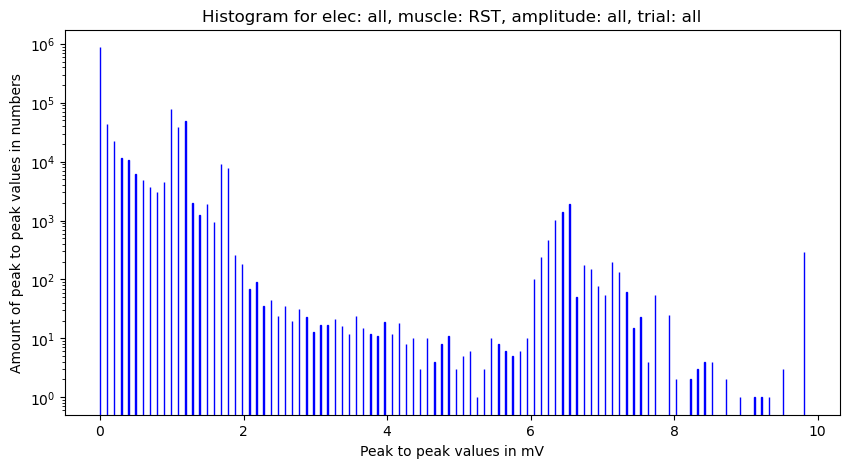

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


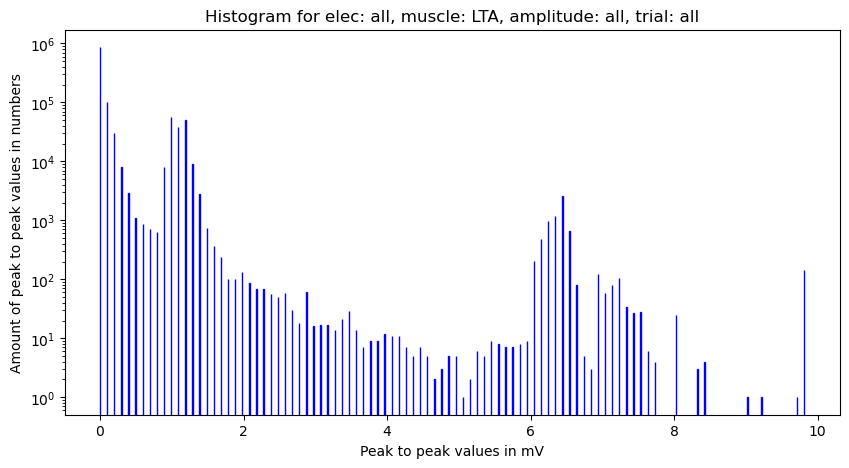

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


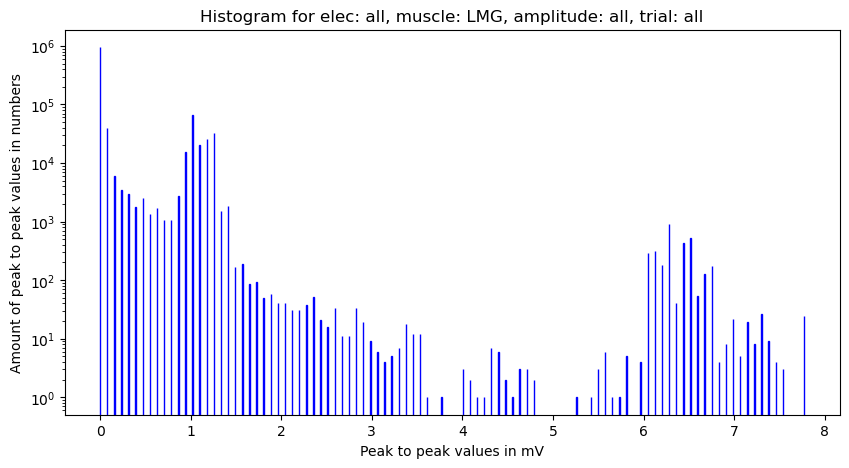

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


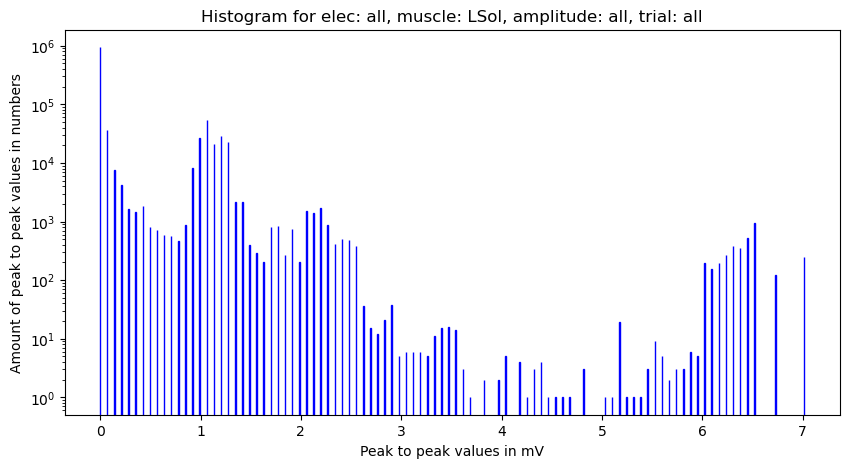

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


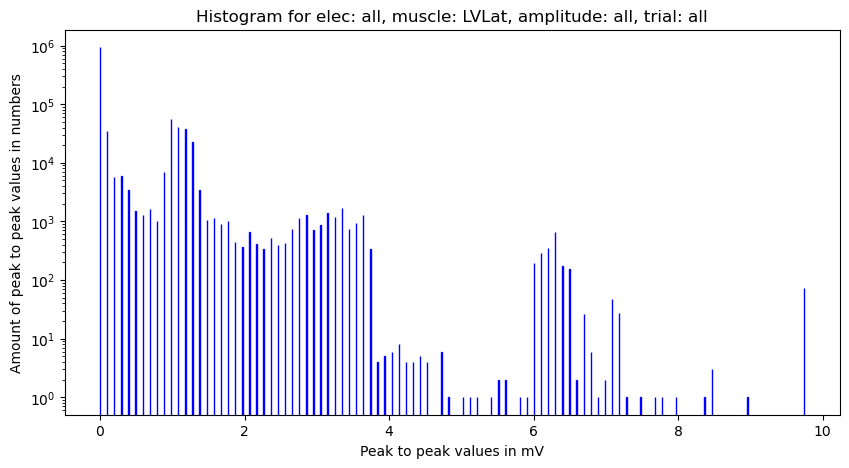

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


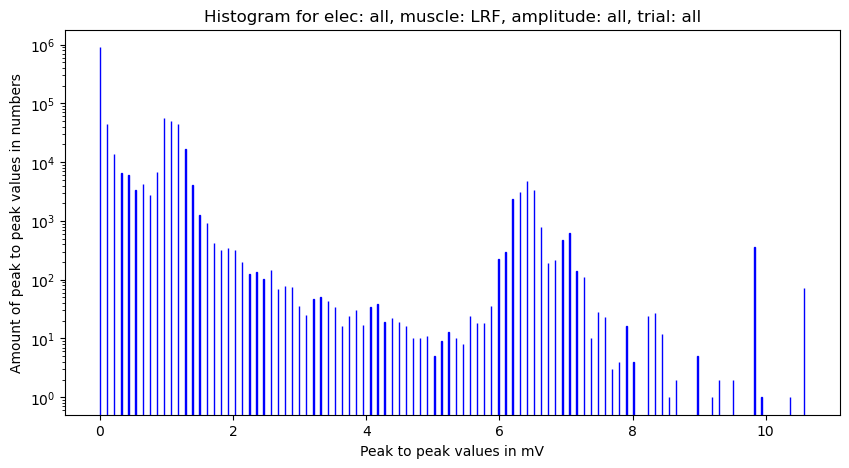

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


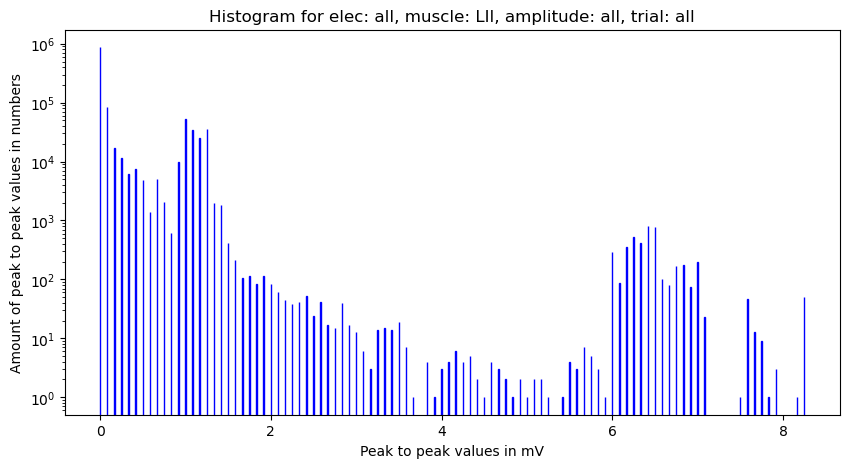

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


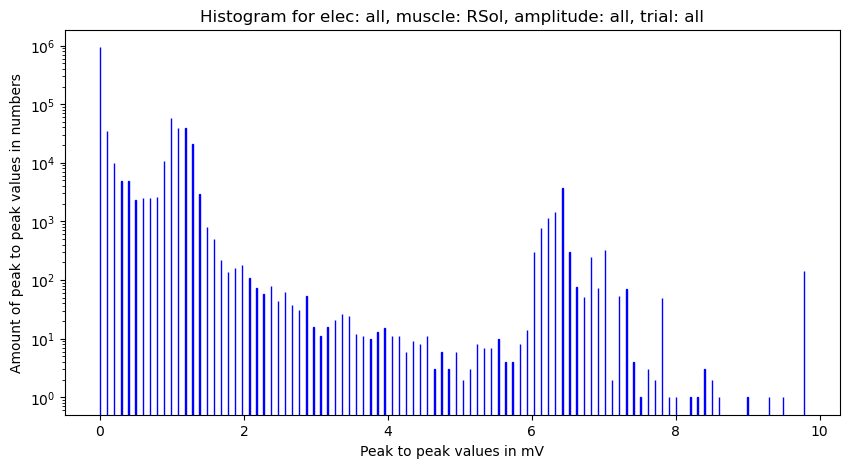

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


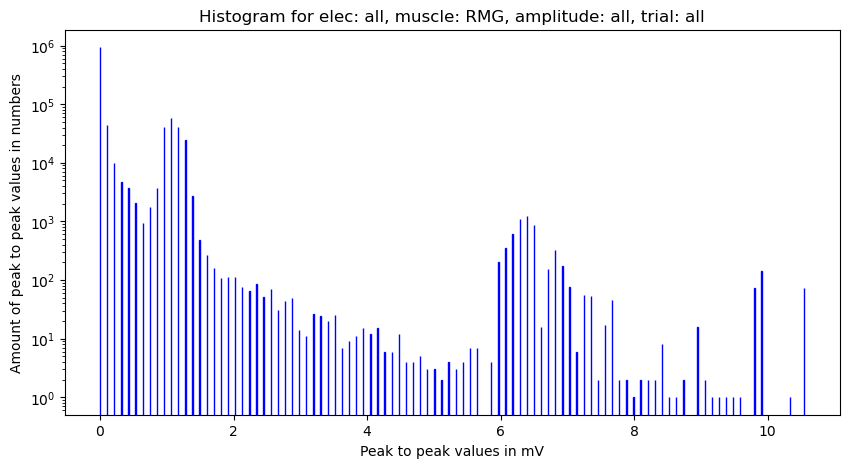

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


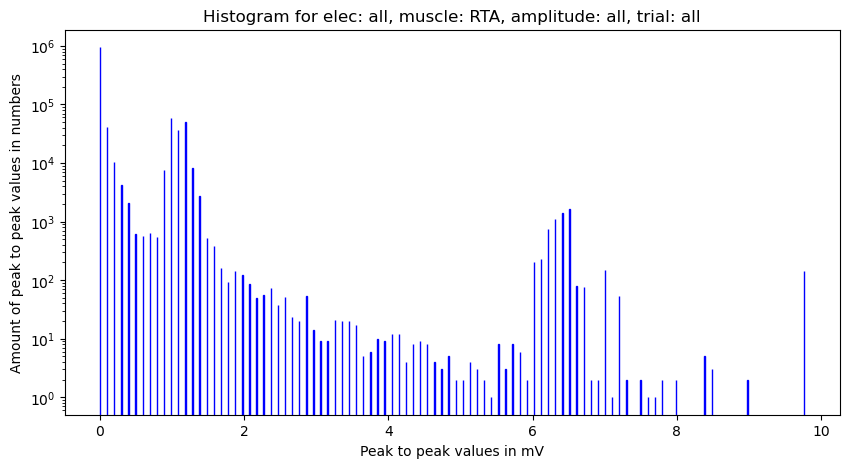

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


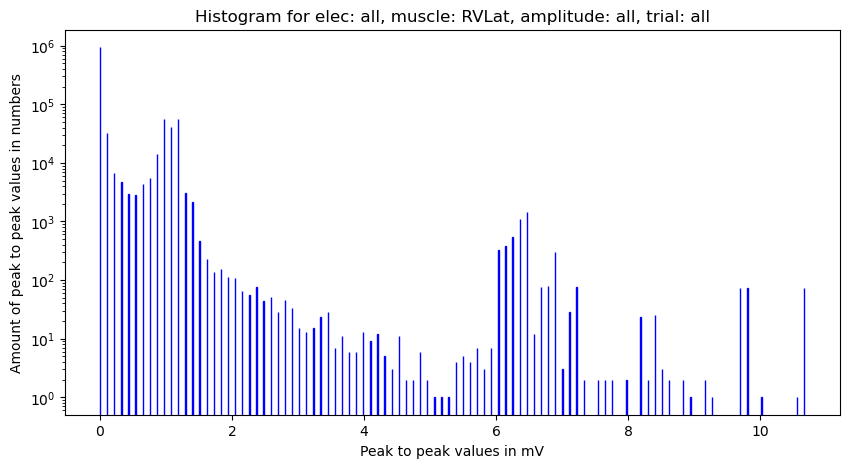

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


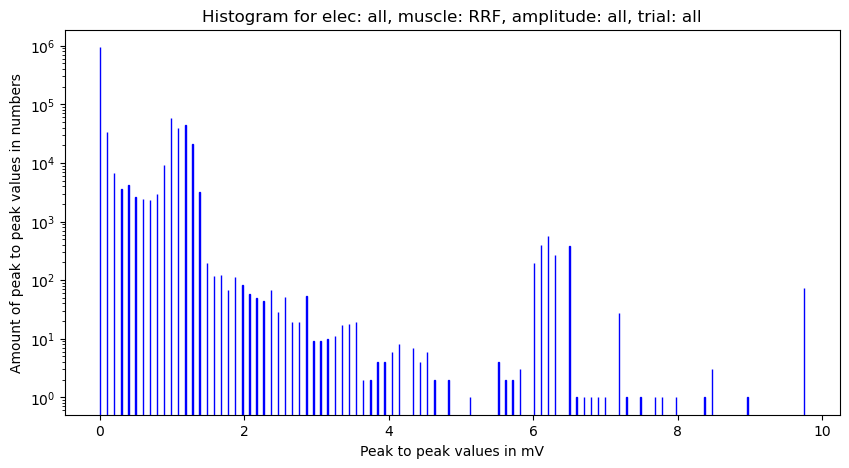

function 'get_peak_to_peak' has been called
torch.Size([1182758])
torch.Size([1182758])
function 'get_histogram' has been called
muscle is specific


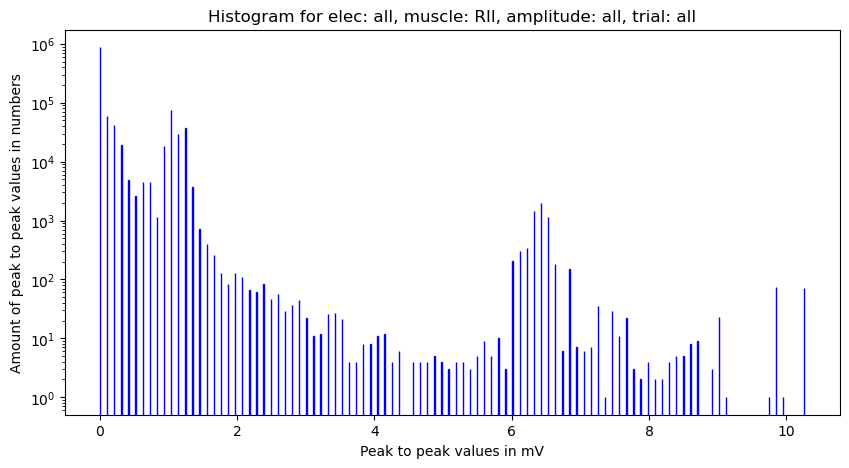

In [111]:
histogram_indvidual_muscle_all_elecs={}
for muscle in range (len(raw_data_to_tensor[0,:,0,0,0])):
    histogram_indvidual_muscle_all_elecs[df_muscles.iloc[muscle]['muscle_name']]=get_histogram(get_peak_to_peak(raw_data_to_tensor[:,muscle,:,:,:], 100), bins=100, muscle=muscle)
    